In [1]:
import geopandas as gpd
import pandas as pd
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, MultiPoint
from shapely import set_precision
import contextily as ctx
from shapely.ops import unary_union, linemerge, snap
from shapely.validation import make_valid
from math import isfinite
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pickle


## Counties

In [18]:
counties = gpd.read_file('../raw data/county level data/tl_2025_us_county/tl_2025_us_county.shp').to_crs(5070)
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,40,075,01101825,40075,0500000US40075,Kiowa,Kiowa County,06,H1,G4020,None,None,None,A,2629039892,40296743,+34.9214893,-098.9816168,"POLYGON ((-267035.259 1343980.561, -266490.502..."
1,46,079,01265776,46079,0500000US46079,Lake,Lake County,06,H1,G4020,None,None,None,A,1457916151,31746795,+44.0284497,-097.1232229,"POLYGON ((-71100.31 2327435.998, -71100.293 23..."
2,37,033,01008542,37033,0500000US37033,Caswell,Caswell County,06,H1,G4020,None,None,None,A,1102042927,8293623,+36.3943252,-079.3396193,"POLYGON ((1489331.21 1620697.325, 1489336.836 ..."
3,48,377,01383974,48377,0500000US48377,Presidio,Presidio County,06,H1,G4020,None,None,None,A,9985057447,1773188,+30.0058912,-104.2616192,"POLYGON ((-857749.848 879396.771, -857744.209 ..."
4,39,057,01074041,39057,0500000US39057,Greene,Greene County,06,H1,G4020,212,19430,None,A,1071302625,6798109,+39.6874785,-083.8948943,"POLYGON ((1008169.795 1915287.022, 1008161.905..."


In [19]:
counties.shape

(3235, 19)

In [20]:
counties = counties[~counties.STATEFP.isin(['02', '14', '15', '72', '07', '03', '43', '52', '78', '72', '69', '66', '60'])]
counties.shape

(3109, 19)

In [21]:
counties['centroid'] = counties.geometry.centroid
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid
0,40,075,01101825,40075,0500000US40075,Kiowa,Kiowa County,06,H1,G4020,None,None,None,A,2629039892,40296743,+34.9214893,-098.9816168,"POLYGON ((-267035.259 1343980.561, -266490.502...",POINT (-270070.971 1321674.415)
1,46,079,01265776,46079,0500000US46079,Lake,Lake County,06,H1,G4020,None,None,None,A,1457916151,31746795,+44.0284497,-097.1232229,"POLYGON ((-71100.31 2327435.998, -71100.293 23...",POINT (-90223.338 2337302.331)
2,37,033,01008542,37033,0500000US37033,Caswell,Caswell County,06,H1,G4020,None,None,None,A,1102042927,8293623,+36.3943252,-079.3396193,"POLYGON ((1489331.21 1620697.325, 1489336.836 ...",POINT (1473665.516 1612333.443)
3,48,377,01383974,48377,0500000US48377,Presidio,Presidio County,06,H1,G4020,None,None,None,A,9985057447,1773188,+30.0058912,-104.2616192,"POLYGON ((-857749.848 879396.771, -857744.209 ...",POINT (-793168.208 803695.173)
4,39,057,01074041,39057,0500000US39057,Greene,Greene County,06,H1,G4020,212,19430,None,A,1071302625,6798109,+39.6874785,-083.8948943,"POLYGON ((1008169.795 1915287.022, 1008161.905...",POINT (1026417.426 1917896.79)


In [22]:
counties.COUNTYFP = counties.STATEFP + counties.COUNTYFP
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid
0,40,40075,01101825,40075,0500000US40075,Kiowa,Kiowa County,06,H1,G4020,None,None,None,A,2629039892,40296743,+34.9214893,-098.9816168,"POLYGON ((-267035.259 1343980.561, -266490.502...",POINT (-270070.971 1321674.415)
1,46,46079,01265776,46079,0500000US46079,Lake,Lake County,06,H1,G4020,None,None,None,A,1457916151,31746795,+44.0284497,-097.1232229,"POLYGON ((-71100.31 2327435.998, -71100.293 23...",POINT (-90223.338 2337302.331)
2,37,37033,01008542,37033,0500000US37033,Caswell,Caswell County,06,H1,G4020,None,None,None,A,1102042927,8293623,+36.3943252,-079.3396193,"POLYGON ((1489331.21 1620697.325, 1489336.836 ...",POINT (1473665.516 1612333.443)
3,48,48377,01383974,48377,0500000US48377,Presidio,Presidio County,06,H1,G4020,None,None,None,A,9985057447,1773188,+30.0058912,-104.2616192,"POLYGON ((-857749.848 879396.771, -857744.209 ...",POINT (-793168.208 803695.173)
4,39,39057,01074041,39057,0500000US39057,Greene,Greene County,06,H1,G4020,212,19430,None,A,1071302625,6798109,+39.6874785,-083.8948943,"POLYGON ((1008169.795 1915287.022, 1008161.905...",POINT (1026417.426 1917896.79)


## Highways

Weights are $W^H_{i,j} = \frac{M_i M_j}{C_{ij}^2}$, where $M_i = \sum_i \text{AADT} \times \text{lanes} \times \text{miles}$ and $C_{ij}$ is the shortest travel time between the centroids of states $i$ and $j$. Weights are then normalized by dividing by the maximum value.

In [19]:
highways = gpd.read_file('../raw data/state level data/NHS/National_Highway_System_(NHS).shp').to_crs(5070)

In [20]:
highways.head()

,VERSION,YEAR,STFIPS,CTFIPS,ROUTEID,BEGINPOINT,ENDPOINT,SIGN1,SIGNT1,SIGNN1,...,AADT,AADT_COM,AADT_SINGL,FUT_AADT,FUT_YEAR,MILES,UPDATE_DAT,NHS_ACTION,FILE_NAME,geometry
0,2025.08.08,2020.0,2.0,290.0,1260000X000,157.02,176.061,S11,S,11,...,140.0,55.0,49.0,290.0,2039-12-31,17.912424,1899-12-30,None,AK_NHS_2021,"LINESTRING (-2815788.299 5548157.738, -2815782..."
1,2025.08.08,2020.0,15.0,7.0,50,0.00,6.690,S50,S,50,...,21200.0,102.0,981.0,26316.0,2039-12-31,0.949648,1899-12-30,None,HI_NHS_2021,"LINESTRING (-6210931.354 2039978.063, -6211970..."
2,2025.08.08,2020.0,15.0,7.0,50,0.00,6.690,S50,S,50,...,18800.0,128.0,356.0,23336.0,2039-12-31,1.429447,1899-12-30,None,HI_NHS_2021,"LINESTRING (-6217092.781 2043542.994, -6217542..."
3,2025.08.08,2020.0,15.0,7.0,50,0.00,6.690,S50,S,50,...,18800.0,128.0,356.0,23336.0,2039-12-31,2.889823,1899-12-30,None,HI_NHS_2021,"LINESTRING (-6212980.171 2040628.08, -6213038...."
4,2025.08.08,2020.0,15.0,7.0,50,0.00,6.690,S50,S,50,...,18800.0,128.0,356.0,23336.0,2039-12-31,0.249906,1899-12-30,None,HI_NHS_2021,"LINESTRING (-6216762.315 2043301.338, -6216782..."


In [21]:
highways.shape

(492005, 34)

In [22]:
interstates = highways[highways.SIGNT1 == 'I']

In [23]:
interstates = interstates[['STFIPS', 'CTFIPS', 'ROUTEID', 'SIGNN1', 'LNAME', 'SPEED_LIMI','AADT','THROUGH_LA','MILES', 'geometry']]

In [24]:
interstates.STFIPS = interstates.STFIPS.astype(int).astype(str)
interstates.CTFIPS = interstates.CTFIPS.astype(int).astype(str).str.zfill(3)
interstates.head()

,STFIPS,CTFIPS,ROUTEID,SIGNN1,LNAME,SPEED_LIMI,AADT,THROUGH_LA,MILES,geometry
178,15,003,H-3,3,None,55.0,23300.0,4.0,1.937658,"LINESTRING (-6117769.715 1888720.406, -6117929..."
187,15,003,H-1,1,None,45.0,85000.0,8.0,0.817908,"LINESTRING (-6124591.086 1879598.533, -6124586..."
189,15,003,H-1,1,None,60.0,77000.0,6.0,4.050123,"LINESTRING (-6143755.039 1901404.787, -6143656..."
205,15,003,H-1,1,None,35.0,33700.0,6.0,0.513067,"LINESTRING (-6144557.734 1901229.024, -6144550..."
206,15,003,H-1,1,None,25.0,33700.0,5.0,0.324021,"LINESTRING (-6145061.62 1901331.356, -6145060...."


In [25]:
interstates.STFIPS = interstates.STFIPS.astype(int).astype(str).str.zfill(2)

In [26]:
interstates = interstates[~interstates.STFIPS.isin(['02', '14', '15', '72', '07', '03', '43', '52', '78', '72', '69', '66', '60'])]

In [27]:
interstates.SPEED_LIMI = interstates.SPEED_LIMI.apply(lambda x: 65 if x < 45 else x)

## Graph construction

In [28]:
interstates["geometry"] = interstates["geometry"].apply(make_valid)

In [29]:
# explode multilines so we work with LineString pieces
interstates = interstates.explode(index_parts=False).reset_index(drop=True)


In [30]:
interstates["geometry"] = interstates.geometry.apply(lambda g: set_precision(g, 200))

In [31]:
U = unary_union(interstates.geometry)  # noding happens here

def iter_lines(geom):
    if geom.is_empty: 
        return
    if isinstance(geom, LineString):
        yield geom
    elif isinstance(geom, MultiLineString):
        for l in geom.geoms:
            yield from iter_lines(l)
    else:
        m = linemerge(geom)
        if isinstance(m, (LineString, MultiLineString)):
            yield from iter_lines(m)

noded_lines = list(iter_lines(U))
noded = gpd.GeoDataFrame(geometry=noded_lines, crs=interstates.crs)
noded = noded.reset_index().rename(columns={"index":"nid"})

In [32]:
noded_attr = gpd.overlay(noded, interstates[['AADT', 'THROUGH_LA', 'SPEED_LIMI', "geometry"]],
                         how="identity", keep_geom_type=False)

In [33]:
noded_attr["miles_piece"] = noded_attr.length * 0.000621371

In [34]:
w = noded_attr["miles_piece"].clip(lower=1e-6)
agg = (noded_attr
       .assign(w=w)
       .groupby("nid")
       .apply(lambda df: pd.Series({
           "miles_piece": df["miles_piece"].sum(),
           "speed": np.average(df['SPEED_LIMI'], weights=df["w"]),
           "AADT":  np.average(df['AADT'],  weights=df["w"]),
           "lanes": np.average(df['THROUGH_LA'],  weights=df["w"]),
       }))
       .reset_index())

noded_final = noded.merge(agg, on="nid", how="left")
noded_final["travel_min"] = (noded_final["miles_piece"] / noded_final["speed"].clip(lower=1e-6)) * 60.0


C:\Users\hkdeb\AppData\Local\Temp\ipykernel_19884\1484928858.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = (noded_attr


In [35]:
noded_final.rename({'speed':'SPEED_LIMI', 'lanes':'THROUGH_LA', 'miles_piece':'MILES'}, axis=1, inplace=True)

In [44]:
counties.geom_type.value_counts()

Polygon         3070
MultiPolygon      39
Name: count, dtype: int64

In [45]:
seg_in_county = gpd.overlay(
    interstates[['AADT', 'THROUGH_LA', 'MILES', "geometry"]],
    counties[['COUNTYFP', "geometry"]],
    how="intersection",
    keep_geom_type=True,
)


In [47]:
seg_in_county.to_file('../raw data/county level data/seg_in_county.shp')

In [169]:
# seg_in_county = gpd.read_file('../raw data/state level data/NHS/highway_overlay_shp/seg_in_state.shp')
# seg_in_county.head()

,AADT,THROUGH_LA,MILES,STATEFP,geometry
0,50820.0,6.0,2.778024,01,"LINESTRING (866424.522 1207073.849, 866424.798..."
1,76838.0,6.0,1.519560,01,"LINESTRING (851820.231 1205919.896, 851829.631..."
2,106959.0,8.0,0.323112,01,"LINESTRING (844364.383 1205648.375, 844318.657..."
3,58241.0,6.0,1.927683,01,"LINESTRING (861612.447 1206535.993, 861612.935..."
4,32000.0,4.0,2.295514,05,"LINESTRING (195992.211 1166853.839, 195994.693..."


In [48]:
seg_in_county["part_miles"] = seg_in_county.length * 0.000621371

In [49]:
seg_in_county["cap"] = (
    seg_in_county['AADT'].astype(float).fillna(0.0)
    * seg_in_county['THROUGH_LA'].astype(float).fillna(1.0)
    * seg_in_county["part_miles"].clip(lower=1e-6)
)

M_by_county = (
    seg_in_county.groupby('COUNTYFP', as_index=False)["cap"].sum()
    .rename(columns={"cap": "M"})
)


In [51]:
seg_in_county.head()

,AADT,THROUGH_LA,MILES,COUNTYFP,geometry,part_miles,cap
0,50820.0,6.0,2.778024,01073,"MULTILINESTRING ((866400 1207000, 866600 12072...",3.167163,965731.328104
1,50820.0,6.0,2.778024,01115,"LINESTRING (869800 1209200, 870000 1209200)",0.124274,37893.689064
2,76838.0,6.0,1.519560,01073,"LINESTRING (851800 1206000, 852000 1206000, 85...",1.915589,883140.192736
3,106959.0,8.0,0.323112,01073,"LINESTRING (844400 1205600, 844400 1205800, 84...",0.497097,425351.813050
4,58241.0,6.0,1.927683,01073,"LINESTRING (861600 1206600, 861600 1206800, 86...",1.988387,694833.953491


In [50]:
M_by_county

,COUNTYFP,M
0,01001,3.256391e+06
1,01003,9.189667e+06
2,01009,2.168118e+06
3,01013,5.202935e+06
4,01015,2.167815e+06
...,...,...
1424,56025,1.903399e+06
1425,56031,2.179180e+06
1426,56033,1.205251e+06
1427,56037,8.539975e+06


In [52]:
counties = counties.merge(M_by_county, on='COUNTYFP', how="left")
counties["M"] = counties["M"].fillna(0.0)


In [53]:
def iter_lines(geom):
    """Yield LineString pieces from geometry, flattening MultiLineString."""
    if geom is None or geom.is_empty:
        return
    if isinstance(geom, LineString):
        yield geom
    elif isinstance(geom, MultiLineString):
        for ls in geom.geoms:
            if not ls.is_empty:
                yield ls

def coords2node(x, y, ndp=6):
    """Quantize coordinates for stable node keys (avoid floating-point duplicates)."""
    return round(float(x), ndp), round(float(y), ndp)


In [54]:
G = nx.Graph()

for _, r in noded_final.iterrows():
    speed = float(r['SPEED_LIMI'])
    miles = float(r['MILES'])
    # Guard against weird rows
    if not (isfinite(speed) and isfinite(miles)) or miles <= 0 or speed <= 0:
        continue
    travel_min = (miles / speed) * 60.0

    for ls in iter_lines(r.geometry):
        # Connect segment endpoints (you could also break at every vertex, but endpoints suffice for routing here)
        x0, y0 = ls.coords[0]
        x1, y1 = ls.coords[-1]
        u = coords2node(x0, y0)
        v = coords2node(x1, y1)
        # Combine parallel edges by keeping the minimum time (or sum—here min is reasonable)
        if G.has_edge(u, v):
            G[u][v]["travel_min"] = min(G[u][v]["travel_min"], travel_min)
            G[u][v]["miles"] = min(G[u][v]["miles"], miles)
        else:
            G.add_edge(u, v, travel_min=travel_min, miles=miles)


In [55]:
components = list(nx.connected_components(G))
len(components)

11

In [56]:
[len(c) for c in components]

[54188, 174, 43, 8, 5, 3, 4, 471, 9, 3, 3]

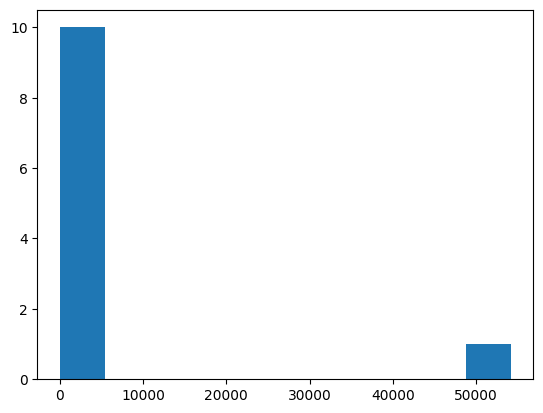

In [57]:
plt.hist([len(c) for c in components])
plt.show()

In [58]:
largest_nodes = max(components, key=len)

In [59]:
G = G.subgraph(largest_nodes).copy()

<Axes: >

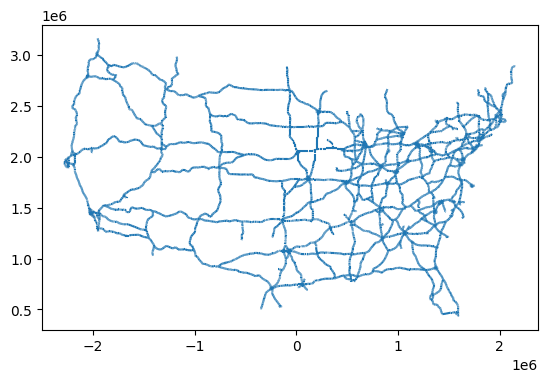

In [60]:
def graph_edges_gdf(G, crs):
    rows = []
    for u, v, d in G.edges(data=True):
        rows.append({
            "u": u, "v": v,
            "travel_min": d.get("travel_min", np.nan),
            "miles": d.get("miles", np.nan),
            "geometry": LineString([u, v]),
        })
    return gpd.GeoDataFrame(rows, geometry="geometry", crs=crs)

edges_gdf = graph_edges_gdf(G, crs=counties.crs)  # G nodes are (x,y) in same CRS as `states`
edges_gdf.plot()

In [61]:
node_xy = np.array(list(G.nodes))

In [62]:
kdt = cKDTree(node_xy)
def nearest_node(pt):
    d, idx = kdt.query([pt.x, pt.y])
    return tuple(node_xy[idx])
counties["graph_node"] = counties["centroid"].apply(nearest_node)

In [63]:
for n in counties.graph_node:
    if n not in G:
        print('False')

In [69]:
n = len(counties)
T = np.full((n, n), np.inf, dtype=float)
county_ids = counties['COUNTYFP'].tolist()

In [64]:
# Precompute single-source Dijkstra from each anchor
for i, src in enumerate(counties["graph_node"]):
    # print(src)
    dist = nx.single_source_dijkstra_path_length(G, src, weight="travel_min")
    # print(len(dist))
    # Map to destination anchors
    for j, dst in enumerate(counties["graph_node"]):
        T[i, j] = dist[dst]

In [65]:
# Clean up any zeros/diagonal
for i in range(n):
    T[i, i] = np.inf  # set to inf so weight becomes 0 on diagonal


In [68]:
T[:5, :5]

array([[          inf,  733.51684589, 1303.21628308,  619.28733266,
         908.25119038],
       [ 733.51684589,           inf, 1434.64065383, 1214.88860136,
         859.66163482],
       [1303.21628308, 1434.64065383,           inf, 1541.52730255,
         620.23042936],
       [ 619.28733266, 1214.88860136, 1541.52730255,           inf,
        1385.21447932],
       [ 908.25119038,  859.66163482,  620.23042936, 1385.21447932,
                  inf]])

In [70]:
alpha = 1 # state mass weight
beta = 2 # travel time weight

In [82]:
M = counties["M"].to_numpy()  # shape (n,)
# Impedance matrix C = T (minutes). Avoid divide-by-zero/infs later.
C = np.where(np.isfinite(T) & (T > 0), T, np.nan)

# w_ij = (M_i^alpha * M_j^alpha) / (C_ij^beta)
W = (M[:, None]**alpha) * (M[None, :]**alpha) / (C**beta)
W[~np.isfinite(W)] = 0.0
np.fill_diagonal(W, 0.0)

# row_sums = W.sum(axis=1, keepdims=True)
# # Avoid division by zero for isolated states (no interstate mass or disconnected)
# W = np.divide(W, np.where(row_sums == 0, 1.0, row_sums))


In [107]:
masses_df = pd.DataFrame(M, index=county_ids, columns=['mass'])

In [108]:
travel_times_df = pd.DataFrame(T, index=county_ids, columns=county_ids)

In [83]:
weights = pd.DataFrame(W, index=county_ids, columns=county_ids)

In [95]:
row_states = {s[:2] for s in weights.index}
col_states = {s[:2] for s in weights.columns}
states = sorted(row_states & col_states)

In [97]:
blocks = {}
for st in states:
    rows = weights.index[weights.index.str.startswith(st)]
    cols = weights.columns[weights.columns.str.startswith(st)]
    # For a symmetric matrix that’s county×county, rows and cols should match—but intersect to be safe:
    idx = rows.intersection(cols)
    if len(idx):
        blocks[st] = weights.loc[idx, idx]


In [103]:
with open('../processed data/county level/county_highway_weights_by_state.pkl', "wb") as f:
    pickle.dump(blocks, f, protocol=pickle.HIGHEST_PROTOCOL)

In [113]:
blocks_travel_times = {}
for st in states:
    rows = travel_times_df.index[travel_times_df.index.str.startswith(st)]
    cols = travel_times_df.columns[travel_times_df.columns.str.startswith(st)]
    # For a symmetric matrix that’s county×county, rows and cols should match—but intersect to be safe:
    idx = rows.intersection(cols)
    if len(idx):
        blocks_travel_times[st] = travel_times_df.loc[idx, idx]


In [115]:
with open('../processed data/county level/county_highway_travel_times_by_state.pkl', "wb") as f:
    pickle.dump(blocks_travel_times, f, protocol=pickle.HIGHEST_PROTOCOL)

## Airports

Weights are $W^A_i = \sum_{j} \frac{E_i E_j}{\max(E_{i,j})}$, where $E_i$ is the total enplanement of all airports within a 20 mile radius of state $i$ and $\max(E_{i,j})$ is the maximum enplanement value. Weights are then normalized by dividing by the maximum value.

In [2]:
airports = pd.read_excel('../raw data/state level data/all-airport-data.xlsx')
airports.head()

C:\Documents\courses\.venv\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Site Id,Facility Type,Loc Id,Effective Date,Region,ADO,State Id,State Name,County,County State,...,Airport Elevation Source Date,Fuel Available,Transient Storage,Other Services,Wind Indicator,ICAO Id,NPIAS Hub,NPIAS Role,ARP Latitude DD,ARP Longitude DD
0,50296.01*A,AIRPORT,18AA,2025-10-02,AAL,NONE,AK,ALASKA,HAINES,AK,...,2020-10-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.365047,-135.804906
1,50296.02*H,HELIPORT,AA35,2025-10-02,AAL,NONE,AK,ALASKA,HAINES,AK,...,2014-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.437556,-136.229361
2,50584.11*A,AIRPORT,AK46,2025-10-02,AAL,NONE,AK,ALASKA,MATANUSKA-SUSITNA,AK,...,NaT,NaN,NaN,NaN,N,NaN,NaN,NaN,61.628831,-149.043189
3,50009.*A,AIRPORT,ADK,2025-10-02,AAL,NONE,AK,ALASKA,ALEUTIANS WEST,AK,...,2017-04-04,NaN,NaN,CARGO,Y,PADK,NaN,Local,51.883583,-176.642482
4,50296.03*A,AIRPORT,9AA9,2025-10-02,AAL,NONE,AK,ALASKA,HAINES,AK,...,2017-06-13,NaN,TIE,NaN,NaN,NaN,NaN,NaN,59.403056,-136.019444


In [3]:
airports['NPIAS Hub'].value_counts()

NPIAS Hub
Non-Hub    253
Small       74
Medium      33
Large       31
Name: count, dtype: int64

In [4]:
relevant_airports = airports[airports['NPIAS Hub'].isin(['Large', 'Medium', 'Small'])]

In [6]:
locs = []
for _, row in relevant_airports.iterrows():
    y, x = row['ARP Latitude DD'], row['ARP Longitude DD']  # longitude, latitude
    url = f"https://geocoding.geo.census.gov/geocoder/geographies/coordinates?x={x}&y={y}&benchmark=Public_AR_Current&vintage=Current_Current&format=json"
    response = requests.get(url).json()
    
    fips = response['result']['geographies']['Counties'][0]['GEOID']
    county = response['result']['geographies']['Counties'][0]['NAME']
    locs.append([fips, county])

In [9]:
relevant_airports['COUNTYFP'] = locs

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_19568\861544752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_airports['COUNTYFP'] = locs


In [12]:
relevant_airports = relevant_airports[['Loc Id', 'COUNTYFP', 'NPIAS Hub', 'ARP Latitude DD', 'ARP Longitude DD']]

In [14]:
relevant_airports['COUNTYFP'] = relevant_airports['COUNTYFP'].apply(lambda x: x[0])
relevant_airports

,Loc Id,COUNTYFP,NPIAS Hub,ARP Latitude DD,ARP Longitude DD
226,FAI,02090,Small,64.815356,-147.856667
672,ANC,02020,Medium,61.174085,-149.998138
809,BHM,01073,Small,33.563889,-86.752306
931,HSV,01089,Small,34.637197,-86.775054
1144,LIT,05119,Small,34.729441,-92.224777
...,...,...,...,...,...
18750,GEG,53063,Small,47.619028,-117.535222
18860,ATW,55087,Small,44.258093,-88.519072
18982,MSN,55025,Small,43.139879,-89.337504
19043,MKE,55079,Medium,42.946932,-87.897064


In [15]:
relevant_airports['geometry'] = relevant_airports.apply(lambda row: Point(row['ARP Longitude DD'], row['ARP Latitude DD']), axis=1)

In [23]:
geo_airports = gpd.GeoDataFrame(relevant_airports, geometry='geometry', crs=4326).to_crs(counties.crs)

In [28]:
geo_airports['STATEFP'] = geo_airports.COUNTYFP.apply(lambda x: x[:2])

In [31]:
geo_airports = geo_airports[~geo_airports.STATEFP.isin(['02', '14', '15', '72', '07', '03', '43', '52', '78', '72', '69', '66', '60'])]

In [32]:
large = geo_airports[geo_airports['NPIAS Hub'] == 'Large']
medium = geo_airports[geo_airports['NPIAS Hub'] == 'Medium']
small = geo_airports[geo_airports['NPIAS Hub'] == 'Small']

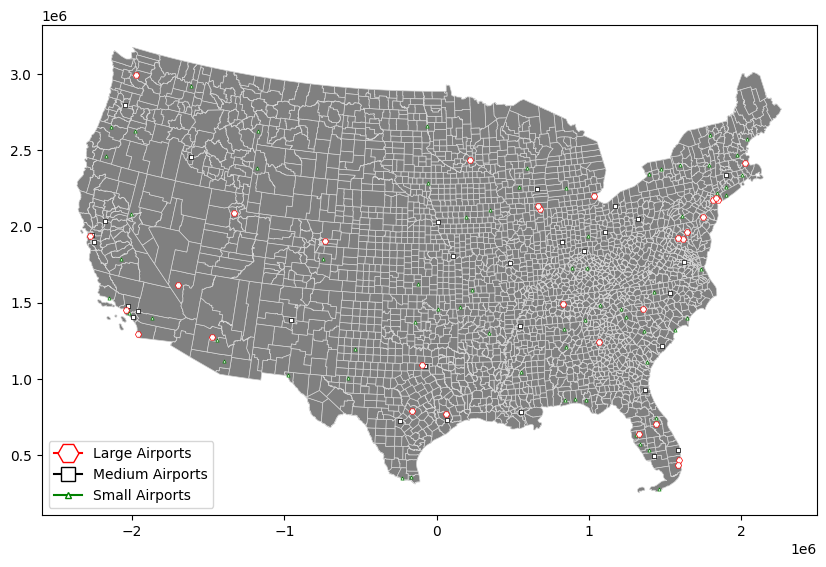

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
counties.plot(ax=ax, facecolor='grey', edgecolor='lightgray', linewidth=0.5, zorder=1)
large.plot(ax=ax, facecolor='white', edgecolor='red', linewidth=0.5, zorder=3, marker='H', markersize=20)
medium.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.5, zorder=2, marker='s', markersize=10)
small.plot(ax=ax, facecolor='white', edgecolor='green', linewidth=0.5, zorder=2, marker='^', markersize=5)
handles = [
    mlines.Line2D([], [], color='red', marker='H', markersize=15,
                  markerfacecolor='white', label='Large Airports'),
    mlines.Line2D([], [], color='black', marker='s', markersize=10,
              markerfacecolor='white', label='Medium Airports'),
    mlines.Line2D([], [], color='green', marker='^', markersize=5,
                  markerfacecolor='white', label='Small Airports'),

]
plt.legend(handles=handles, loc='lower left')
plt.show()

In [34]:
traffic = pd.read_excel('../raw data/state level data/ARP-cy2024-all-enplanements.xlsx')
traffic.head()

C:\Documents\courses\.venv\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,Rank,RO,ST,Locid,City,Airport Name,S/L,Hub,CY 24 Enplanements,CY 23 Enplanements,% Change
0,1.0,AL,AK,ANC,Anchorage,Ted Stevens Anchorage International,P,M,2767856.0,2681818.0,0.0321
1,2.0,AL,AK,FAI,Fairbanks,Fairbanks International,P,S,574012.0,548679.0,0.0462
2,3.0,AL,AK,JNU,Juneau,Juneau International,P,N,436457.0,440279.0,-0.0087
3,4.0,AL,AK,BET,Bethel,Bethel,P,N,165846.0,153548.0,0.0801
4,5.0,AL,AK,KTN,Ketchikan,Ketchikan International,P,N,152082.0,148645.0,0.0231


In [36]:
cand_traffic = geo_airports.merge(traffic[['Locid', 'CY 24 Enplanements']], how='left', left_on='Loc Id', right_on='Locid')

In [38]:
cand_traffic = cand_traffic.drop(['ARP Latitude DD', 'ARP Longitude DD', 'Locid'], axis=1).rename({'CY 24 Enplanements':'enplanements'}, axis=1)

In [39]:
cand_traffic.head()

,Loc Id,COUNTYFP,NPIAS Hub,geometry,STATEFP,enplanements
0,BHM,01073,Small,POINT (851353.105 1207706.738),01,1596510.0
1,HSV,01089,Small,POINT (837638.651 1326903.094),01,804665.0
2,LIT,05119,Small,POINT (342834.67 1303343.92),05,1145693.0
3,XNA,05007,Small,POINT (150613.539 1471613.744),05,1123106.0
4,IWA,04013,Small,POINT (-1441705.4 1256675.903),04,978296.0


In [40]:
mass = cand_traffic.pivot_table(values='enplanements', index='COUNTYFP', aggfunc='sum')

In [41]:
mass.to_csv('../processed data/county level/county_level_airport_masses.csv', index=True)

In [42]:
airweights = pd.DataFrame(np.array(mass) * np.array(mass.T))

In [45]:
np.allclose(airweights, airweights.T, atol=1e-9)

True

In [47]:
airweights.index = airweights.columns = mass.index
np.fill_diagonal(airweights.values, 0)

In [48]:
row_states = {s[:2] for s in airweights.index}
col_states = {s[:2] for s in airweights.columns}
states = sorted(row_states & col_states)

In [49]:
blocks_airweights = {}
for st in states:
    rows = airweights.index[airweights.index.str.startswith(st)]
    cols = airweights.columns[airweights.columns.str.startswith(st)]
    # For a symmetric matrix that’s county×county, rows and cols should match—but intersect to be safe:
    idx = rows.intersection(cols)
    if len(idx):
        blocks_airweights[st] = airweights.loc[idx, idx]

In [50]:
with open('../processed data/county level/county_airport_weights_by_state.pkl', "wb") as f:
    pickle.dump(blocks_airweights, f, protocol=pickle.HIGHEST_PROTOCOL)

## Adjacency Weights

In [53]:
county_adj = pd.read_csv('../raw data/county_adjacency2025.txt', delimiter='|', dtype=str)

In [55]:
county_adj['state_fips'] = county_adj['County GEOID'].apply(lambda x: x[:2])
county_adj = county_adj[~county_adj.state_fips.isin(['02', '14', '15', '72', '07', '03', '43', '52', '78', '72', '69', '66', '60'])]
county_adj.Length = county_adj.Length.astype(float)
county_adj.head()

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_19568\2251183463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_adj.Length = county_adj.Length.astype(float)


,County Name,County GEOID,Neighbor Name,Neighbor GEOID,Length,state_fips
0,"Autauga County, AL",01001,"Chilton County, AL",01021,52283.0,01
1,"Autauga County, AL",01001,"Dallas County, AL",01047,51498.0,01
2,"Autauga County, AL",01001,"Elmore County, AL",01051,32991.0,01
3,"Autauga County, AL",01001,"Lowndes County, AL",01085,59160.0,01
4,"Autauga County, AL",01001,"Montgomery County, AL",01101,14548.0,01


In [56]:
border_adj_matrix = county_adj.pivot_table(index='County GEOID', columns='Neighbor GEOID', aggfunc='sum', values='Length', fill_value=0)
np.fill_diagonal(border_adj_matrix.values, 0)
border_adj_matrix.iloc[:5,:5]

Neighbor GEOID,01001,01003,01005,01007,01009
County GEOID,,,,,
01001,0.0,0.0,0.0,0.0,0.0
01003,0.0,0.0,0.0,0.0,0.0
01005,0.0,0.0,0.0,0.0,0.0
01007,0.0,0.0,0.0,0.0,0.0
01009,0.0,0.0,0.0,0.0,0.0


In [57]:
border_adj_matrix.shape

(3109, 3109)

In [58]:
row_states = {s[:2] for s in border_adj_matrix.index}
col_states = {s[:2] for s in border_adj_matrix.columns}
states = sorted(row_states & col_states)

In [59]:
blocks_adj = {}
for st in states:
    rows = border_adj_matrix.index[border_adj_matrix.index.str.startswith(st)]
    cols = border_adj_matrix.columns[border_adj_matrix.columns.str.startswith(st)]
    # For a symmetric matrix that’s county×county, rows and cols should match—but intersect to be safe:
    idx = rows.intersection(cols)
    if len(idx):
        blocks_adj[st] = border_adj_matrix.loc[idx, idx]

In [60]:
len(blocks_adj)

49

In [61]:
with open('../processed data/county level/county_adj_by_state.pkl', "wb") as f:
    pickle.dump(blocks_adj, f, protocol=pickle.HIGHEST_PROTOCOL)

## State-level Variant Data

In [25]:
variants = pd.read_csv('../raw data/state level data/variant_prevalence_state_level.csv')
variants.head()

,date,total_count,lineage_count,total_count_rolling,lineage_count_rolling,proportion,proportion_ci_lower,proportion_ci_upper,lineage,location
0,2021-01-24,4,1,9.666667,0.166667,0.017241,0.000048,0.217196,Alpha,USA_US-AL
1,2021-01-25,22,3,11.666667,0.666667,0.057143,0.009144,0.328496,Alpha,USA_US-AL
2,2021-01-26,51,2,17.833333,1.000000,0.056075,0.006061,0.231612,Alpha,USA_US-AL
3,2021-01-27,31,1,21.833333,1.166667,0.053435,0.004949,0.193437,Alpha,USA_US-AL
4,2021-01-29,6,1,21.333333,1.333333,0.062500,0.005187,0.201756,Alpha,USA_US-AL


In [26]:
variants.date = pd.to_datetime(variants.date)

In [29]:
prevalences = variants.pivot_table(index=['date', 'location'], columns='lineage', values='proportion').reset_index()

In [32]:
prevalences_21_22 = prevalences[(prevalences.date >= '2021-01-01') & (prevalences.date < '2023-01-01')].reset_index(drop=True)

In [37]:
prevalences_21_22.shape

(34977, 12)

In [55]:
all_days = pd.date_range('2021-01-01', '2022-12-31', freq='D')

def interp_group(g):
    loc = g['location'].iloc[0]
    g = (g.set_index('date')
           .reindex(all_days))              # daily grid
    g.index.name = 'date'
    g['location'] = loc

    num_cols = g.select_dtypes('number').columns
    # interpolate only AFTER the first non-NaN (no backfilling before start)
    g[num_cols] = (g[num_cols]
                     .interpolate(method='time', limit_area='inside')
                     .fillna(0))
    return g.reset_index()

prev_interp = (prevalences_21_22.groupby('location', group_keys=False)
         .apply(interp_group)
         .rename(columns={'index': 'date'}))


C:\Users\hkdeb\AppData\Local\Temp\ipykernel_13612\14715815.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prev_interp = (prevalences_21_22.groupby('location', group_keys=False)


In [56]:
prev_interp['Omicron'] = prev_interp[['omicron_1', 'omicron_2', 'omicron_3', 'omicron_4']].sum(axis=1)

In [57]:
prev_interp.drop(['omicron_1', 'omicron_2', 'omicron_3', 'omicron_4'], axis=1, inplace=True)
prev_interp

lineage,date,location,Alpha,Beta,Delta,Epsilon,Gamma,Iota,Omicron
0,2021-01-01,USA_US-AL,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2021-01-02,USA_US-AL,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,2021-01-03,USA_US-AL,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,2021-01-04,USA_US-AL,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2021-01-05,USA_US-AL,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
725,2022-12-27,USA_US-WY,0.0,0.0,0.0,0.0,0.0,0.0,0.857143
726,2022-12-28,USA_US-WY,0.0,0.0,0.0,0.0,0.0,0.0,0.900000
727,2022-12-29,USA_US-WY,0.0,0.0,0.0,0.0,0.0,0.0,0.933333
728,2022-12-30,USA_US-WY,0.0,0.0,0.0,0.0,0.0,0.0,0.937255


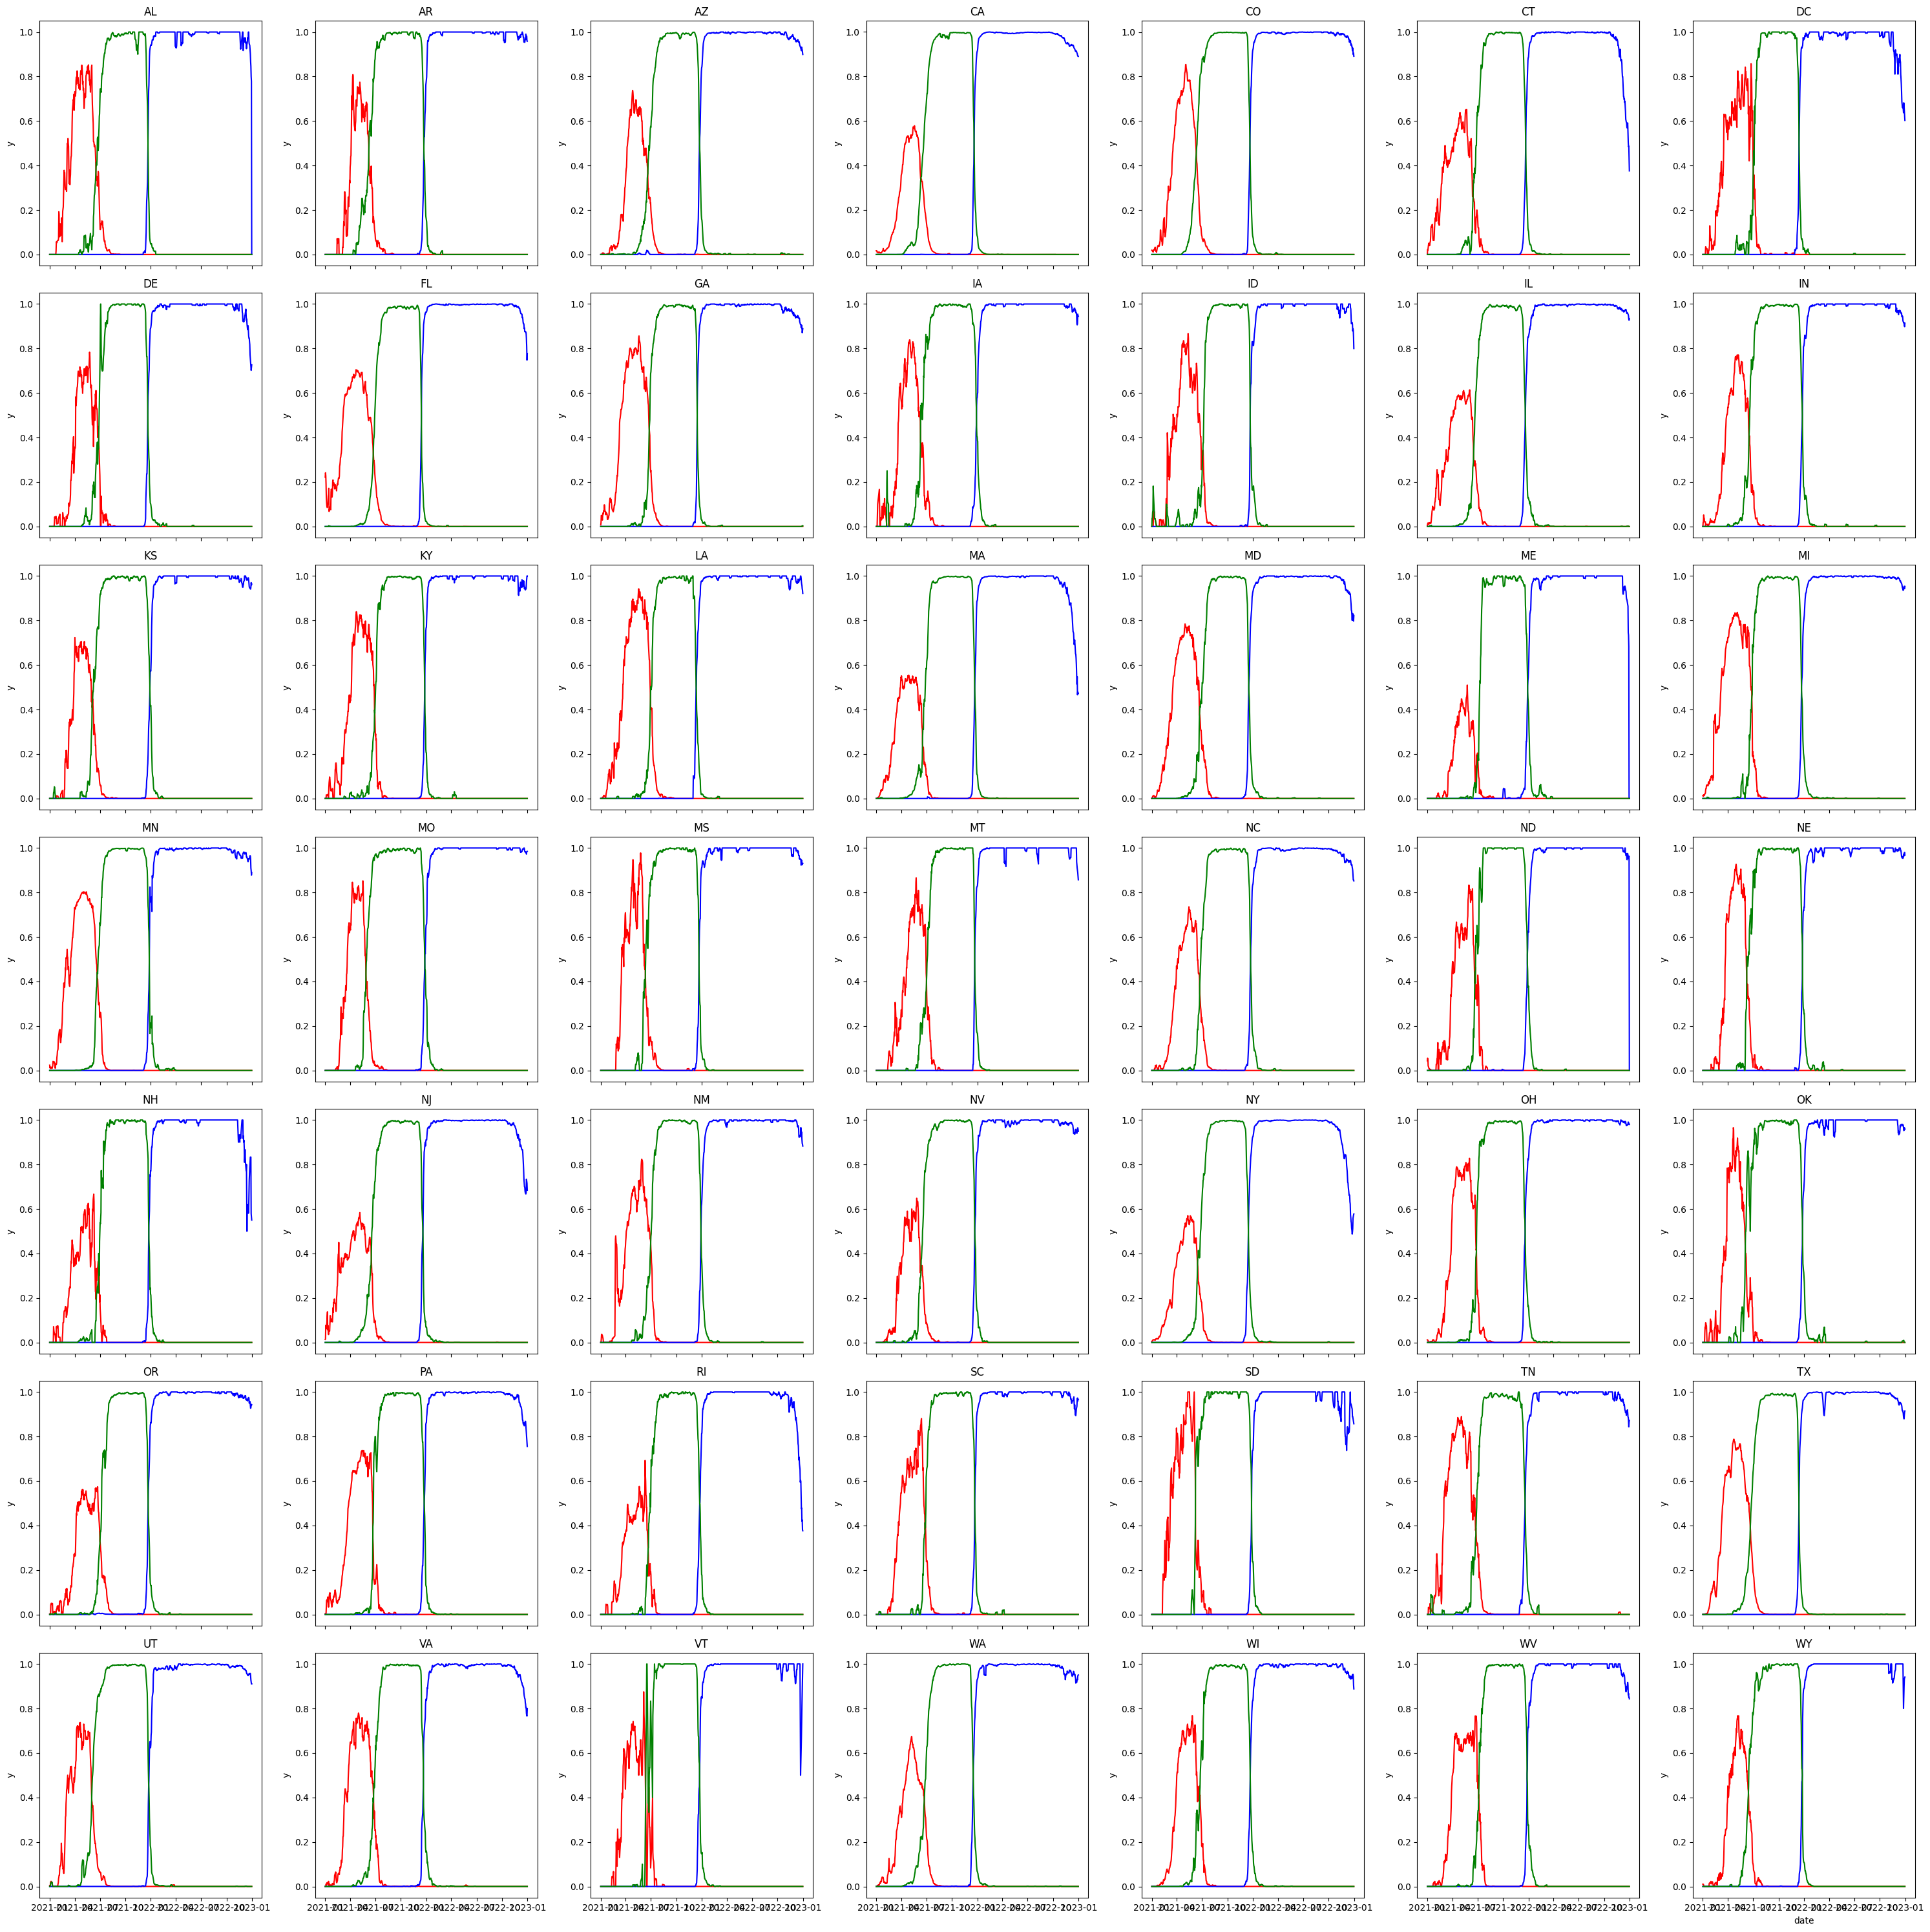

In [58]:
groups = prev_interp['location'].unique()
fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(30, 30), sharex=True)

axes = axes.flatten()

for ax, g in zip(axes, groups):
    sub = prev_interp[prev_interp['location'] == g]
    ax.plot(sub['date'], sub['Alpha'], color='red')
    ax.plot(sub['date'], sub['Omicron'], color='blue')
    ax.plot(sub['date'], sub['Delta'], color='green')
    ax.set_title(f'{g[-2:]}')
    ax.set_ylabel('y')

axes[-1].set_xlabel('date')
plt.tight_layout()
plt.show()


In [65]:
prev_interp.location = prev_interp.location.apply(lambda x: x[-2:])

lineage,date,location,Alpha,Beta,Delta,Epsilon,Gamma,Iota,Omicron
0,2021-01-01,AL,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2021-01-02,AL,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,2021-01-03,AL,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,2021-01-04,AL,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2021-01-05,AL,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
725,2022-12-27,WY,0.0,0.0,0.0,0.0,0.0,0.0,0.857143
726,2022-12-28,WY,0.0,0.0,0.0,0.0,0.0,0.0,0.900000
727,2022-12-29,WY,0.0,0.0,0.0,0.0,0.0,0.0,0.933333
728,2022-12-30,WY,0.0,0.0,0.0,0.0,0.0,0.0,0.937255


In [68]:
prev_interp_comb = prev_interp.merge(states[['STATEFP', 'STUSPS']], left_on='location', right_on='STUSPS', how='left').drop(['location', 'STUSPS'], axis=1).rename({'STATEFP':'location'}, axis=1)

In [70]:
prev_interp_comb.to_csv('../processed data/state_level/state_level_prevalences.csv', index=False)

In [22]:
prev_interp_comb = pd.read_csv('../processed data/state_level/state_level_prevalences.csv')

## Exogenous Variables

In [6]:
exog = pd.read_csv('../raw data/state level data/state level cases.csv')
exog.head()

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_8172\3161734391.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  exog = pd.read_csv('../raw data/state level data/state level cases.csv')


,id,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,...,iso_alpha_3,iso_alpha_2,iso_numeric,iso_currency,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse,key_nuts,key_gadm
0,0042529a,2020-01-12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,THA,TH,764,THB,35,NaN,Yasothon Province,NaN,NaN,THA.77_1
1,0042529a,2020-01-13,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,THA,TH,764,THB,35,NaN,Yasothon Province,NaN,NaN,THA.77_1
2,0042529a,2020-01-14,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,THA,TH,764,THB,35,NaN,Yasothon Province,NaN,NaN,THA.77_1
3,0042529a,2020-01-15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,THA,TH,764,THB,35,NaN,Yasothon Province,NaN,NaN,THA.77_1
4,0042529a,2020-01-16,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,THA,TH,764,THB,35,NaN,Yasothon Province,NaN,NaN,THA.77_1


In [7]:
exog_states = exog[exog.administrative_area_level_1 == 'United States']
exog_states.head()

,id,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,...,iso_alpha_3,iso_alpha_2,iso_numeric,iso_currency,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse,key_nuts,key_gadm
40357,10b692cc,2020-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840,USD,69,NaN,Northern Mariana Islands,US69,NaN,MNP
40358,10b692cc,2020-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840,USD,69,NaN,Northern Mariana Islands,US69,NaN,MNP
40359,10b692cc,2020-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840,USD,69,NaN,Northern Mariana Islands,US69,NaN,MNP
40360,10b692cc,2020-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840,USD,69,NaN,Northern Mariana Islands,US69,NaN,MNP
40361,10b692cc,2020-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,USA,US,840,USD,69,NaN,Northern Mariana Islands,US69,NaN,MNP


In [8]:
exog_states.key_local = exog_states.key_local.astype(int).astype(str).str.zfill(2)

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_8172\1775579615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog_states.key_local = exog_states.key_local.astype(int).astype(str).str.zfill(2)


In [9]:
exog_states = exog_states[~exog_states.key_local.isin(['02', '14', '15', '72', '07', '03', '43', '52', '78', '72', '69', '66', '60'])]

In [10]:
exog_states.key_local.value_counts()

key_local
37    1611
30    1610
18    1602
53    1596
32    1591
25    1590
17    1588
04    1585
51    1584
27    1579
01    1579
48    1579
20    1579
06    1578
55    1576
34    1570
31    1565
54    1559
22    1556
49    1555
05    1552
39    1552
36    1551
26    1551
12    1551
45    1550
21    1550
38    1550
56    1550
44    1550
16    1550
23    1550
40    1550
24    1549
13    1549
33    1549
50    1548
11    1547
47    1547
46    1545
28    1530
29    1526
41    1525
09    1520
19    1519
42    1519
08    1519
10    1518
35    1516
Name: count, dtype: int64

In [12]:
exog_states.columns

Index(['id', 'date', 'confirmed', 'deaths', 'recovered', 'tests', 'vaccines',
       'people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu', 'vent',
       'school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index',
       'administrative_area_level', 'administrative_area_level_1',
       'administrative_area_level_2', 'administrative_area_level_3',
       'latitude', 'longitude', 'population', 'iso_alpha_3', 'iso_alpha_2',
       'iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility',
       'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_g

In [29]:
exog_states = exog_states[['date', 'recovered', 'tests', 'vaccines',
       'people_vaccinated', 'people_fully_vaccinated', 'school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index', 'key_local', 'population']]

In [16]:
exog_states[['school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index']] = exog_states[['school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index']].apply(np.abs)

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_8172\1902630649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog_states[['school_closing', 'workplace_closing', 'cancel_events',


In [18]:
exog_states.date = pd.to_datetime(exog_states.date, format='mixed')

C:\Users\hkdeb\AppData\Local\Temp\ipykernel_8172\3882637526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog_states.date = pd.to_datetime(exog_states.date, format='mixed')


In [30]:
all_days = pd.date_range('2021-01-01', '2022-12-31', freq='D')

def interp_group(g):
    loc = g['key_local'].iloc[0]
    g = (g.set_index('date')
           .reindex(all_days))              # daily grid
    g.index.name = 'date'
    g['key_local'] = loc

    num_cols = g.select_dtypes('number').columns
    # interpolate only AFTER the first non-NaN (no backfilling before start)
    g[num_cols] = (g[num_cols]
                     .interpolate(method='time', limit_area='inside')
                     .fillna(0))
    return g.reset_index()

exog_states_interp = (exog_states.groupby('key_local', group_keys=False)
         .apply(interp_group)
         .rename(columns={'index': 'date'}))


C:\Users\hkdeb\AppData\Local\Temp\ipykernel_8172\2697107677.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exog_states_interp = (exog_states.groupby('key_local', group_keys=False)


In [31]:
exog_states_interp

,date,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,school_closing,workplace_closing,cancel_events,gatherings_restrictions,...,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,economic_support_index,key_local,population
0,2021-01-01,202137.0,3292989.0,52016.0,53829.0,272.0,2.0,1.0,1.0,0.0,...,1.0,3.0,2.0,2.0,49.90,43.52,51.67,37.5,01,4903185
1,2021-01-02,202137.0,3301546.0,52203.0,54052.0,281.0,2.0,1.0,1.0,0.0,...,1.0,3.0,2.0,2.0,49.90,43.52,51.67,37.5,01,4903185
2,2021-01-03,202137.0,3308185.0,53155.0,55046.0,284.0,2.0,1.0,1.0,0.0,...,1.0,3.0,2.0,2.0,49.90,43.52,51.67,37.5,01,4903185
3,2021-01-04,202137.0,3318129.0,59055.0,61092.0,402.0,2.0,1.0,1.0,0.0,...,1.0,3.0,2.0,2.0,49.90,43.52,51.67,37.5,01,4903185
4,2021-01-05,202137.0,3332469.0,67535.0,69520.0,844.0,2.0,1.0,1.0,0.0,...,1.0,3.0,2.0,2.0,49.90,43.52,51.67,37.5,01,4903185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2022-12-27,0.0,1558389.0,846241.0,351988.0,306772.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,1.0,33.33,27.78,38.10,0.0,56,578759
726,2022-12-28,0.0,1558708.0,846601.0,352028.0,306801.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,1.0,33.33,27.78,38.10,0.0,56,578759
727,2022-12-29,0.0,1559121.0,846905.0,352073.0,306826.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,1.0,33.33,27.78,38.10,0.0,56,578759
728,2022-12-30,0.0,1559413.0,847187.0,352115.0,306848.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,1.0,33.33,27.78,38.10,0.0,56,578759


In [32]:
prev_interp_comb.location = prev_interp_comb.location.astype(str).str.zfill(2)
prev_interp_comb.date = pd.to_datetime(prev_interp_comb.date)

In [33]:
covariates = exog_states_interp.merge(prev_interp_comb, left_on=['date', 'key_local'], right_on=['date', 'location'], how='inner')

In [34]:
covariates.columns

Index(['date', 'recovered', 'tests', 'vaccines', 'people_vaccinated',
       'people_fully_vaccinated', 'school_closing', 'workplace_closing',
       'cancel_events', 'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index', 'key_local',
       'population', 'Alpha', 'Beta', 'Delta', 'Epsilon', 'Gamma', 'Iota',
       'Omicron', 'location'],
      dtype='object')

In [36]:
cases = pd.read_csv('../raw data/state level data/us_states_daily cases.csv')
cases.head()

,date,geoid,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53,Washington,1,0.14,0.0,0,0.0,0.0
1,2020-01-22,USA-53,Washington,0,0.14,0.0,0,0.0,0.0
2,2020-01-23,USA-53,Washington,0,0.14,0.0,0,0.0,0.0
3,2020-01-24,USA-53,Washington,0,0.14,0.0,0,0.0,0.0
4,2020-01-24,USA-17,Illinois,1,0.14,0.0,0,0.0,0.0


In [38]:
cases['location'] = cases.geoid.apply(lambda x: x[-2:])
cases.date = pd.to_datetime(cases.date)

In [41]:
fully_combined = covariates.drop('key_local', axis=1).merge(cases[['date', 'location', 'cases', 'deaths']], on=['date', 'location'], how='left')

In [45]:
fully_combined['Other'] = 1 - fully_combined[['Alpha', 'Beta', 'Delta', 'Epsilon', 'Gamma', 'Iota', 'Omicron']].sum(axis=1)

In [49]:
fully_combined[['Alpha', 'Beta', 'Delta', 'Epsilon', 'Gamma', 'Iota', 'Omicron', 'Other']] = fully_combined[['Alpha', 'Beta', 'Delta', 'Epsilon', 'Gamma', 'Iota', 'Omicron', 'Other']].multiply(fully_combined.cases, axis=0).map(lambda x: 0 if x < 0 else x)

In [50]:
fully_combined.columns

Index(['date', 'recovered', 'tests', 'vaccines', 'people_vaccinated',
       'people_fully_vaccinated', 'school_closing', 'workplace_closing',
       'cancel_events', 'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index', 'population',
       'Alpha', 'Beta', 'Delta', 'Epsilon', 'Gamma', 'Iota', 'Omicron',
       'location', 'cases', 'deaths', 'Other'],
      dtype='object')

In [52]:
fully_combined.drop('cases', axis=1, inplace=True)

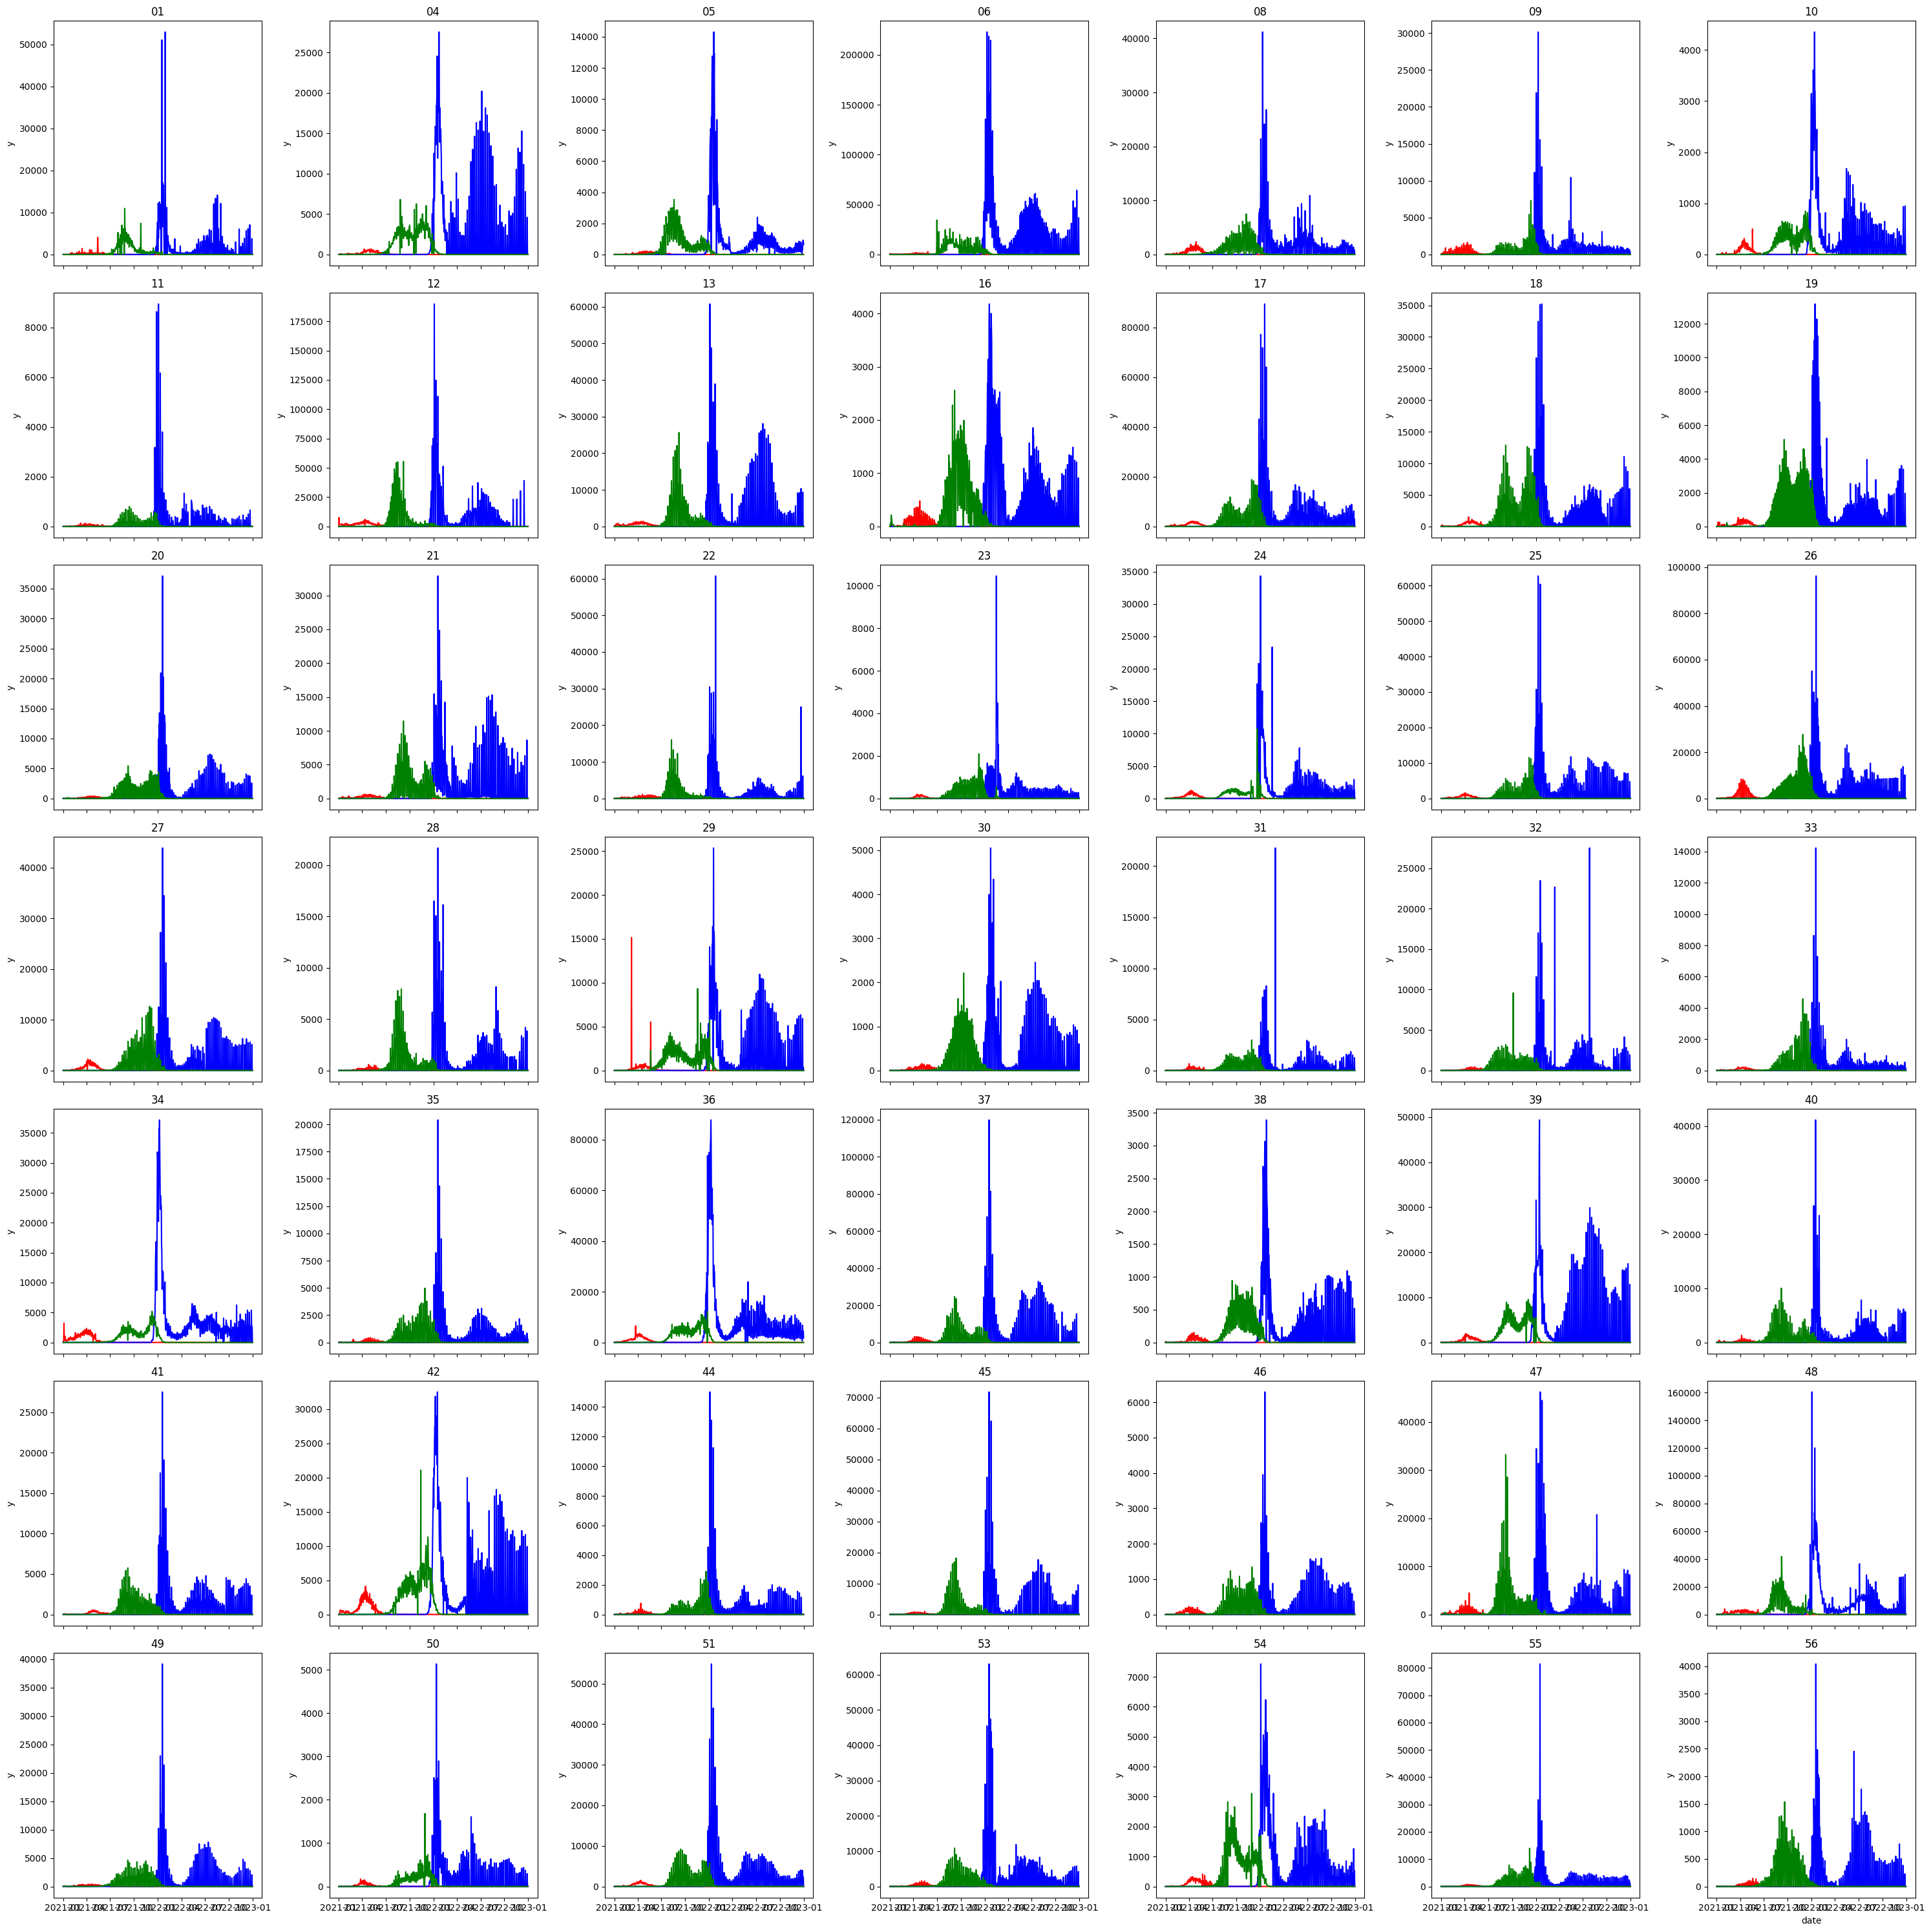

In [53]:
groups = fully_combined['location'].unique()
fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(30, 30), sharex=True)

axes = axes.flatten()

for ax, g in zip(axes, groups):
    sub = fully_combined[fully_combined['location'] == g]
    ax.plot(sub['date'], sub['Alpha'], color='red')
    ax.plot(sub['date'], sub['Omicron'], color='blue')
    ax.plot(sub['date'], sub['Delta'], color='green')
    ax.set_title(f'{g[-2:]}')
    ax.set_ylabel('y')

axes[-1].set_xlabel('date')
plt.tight_layout()
plt.show()


In [58]:
fully_combined.drop(['recovered', 'tests', 'vaccines'], axis=1, inplace=True)

In [74]:
fully_combined = fully_combined[['date', 'location', 'people_vaccinated', 'people_fully_vaccinated',
       'school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index', 'population',
       'Alpha', 'Beta', 'Delta', 'Epsilon', 'Gamma', 'Iota', 'Omicron',
       'deaths', 'Other']]

In [129]:
fully_combined.to_csv('../processed data/state_level/daily_covariates_state_level.csv', index=False)

In [127]:
fully_combined.sort_values(['location', 'date'], inplace=True)

In [130]:
rolled = fully_combined.groupby('location')[fully_combined.columns.to_list()[2:]].transform(lambda s: s.rolling(7, min_periods=1, center=True).mean())

In [131]:
fully_combined_rolling = pd.concat([fully_combined[['date', 'location']].reset_index(drop=True), rolled.reset_index(drop=True)], axis=1)

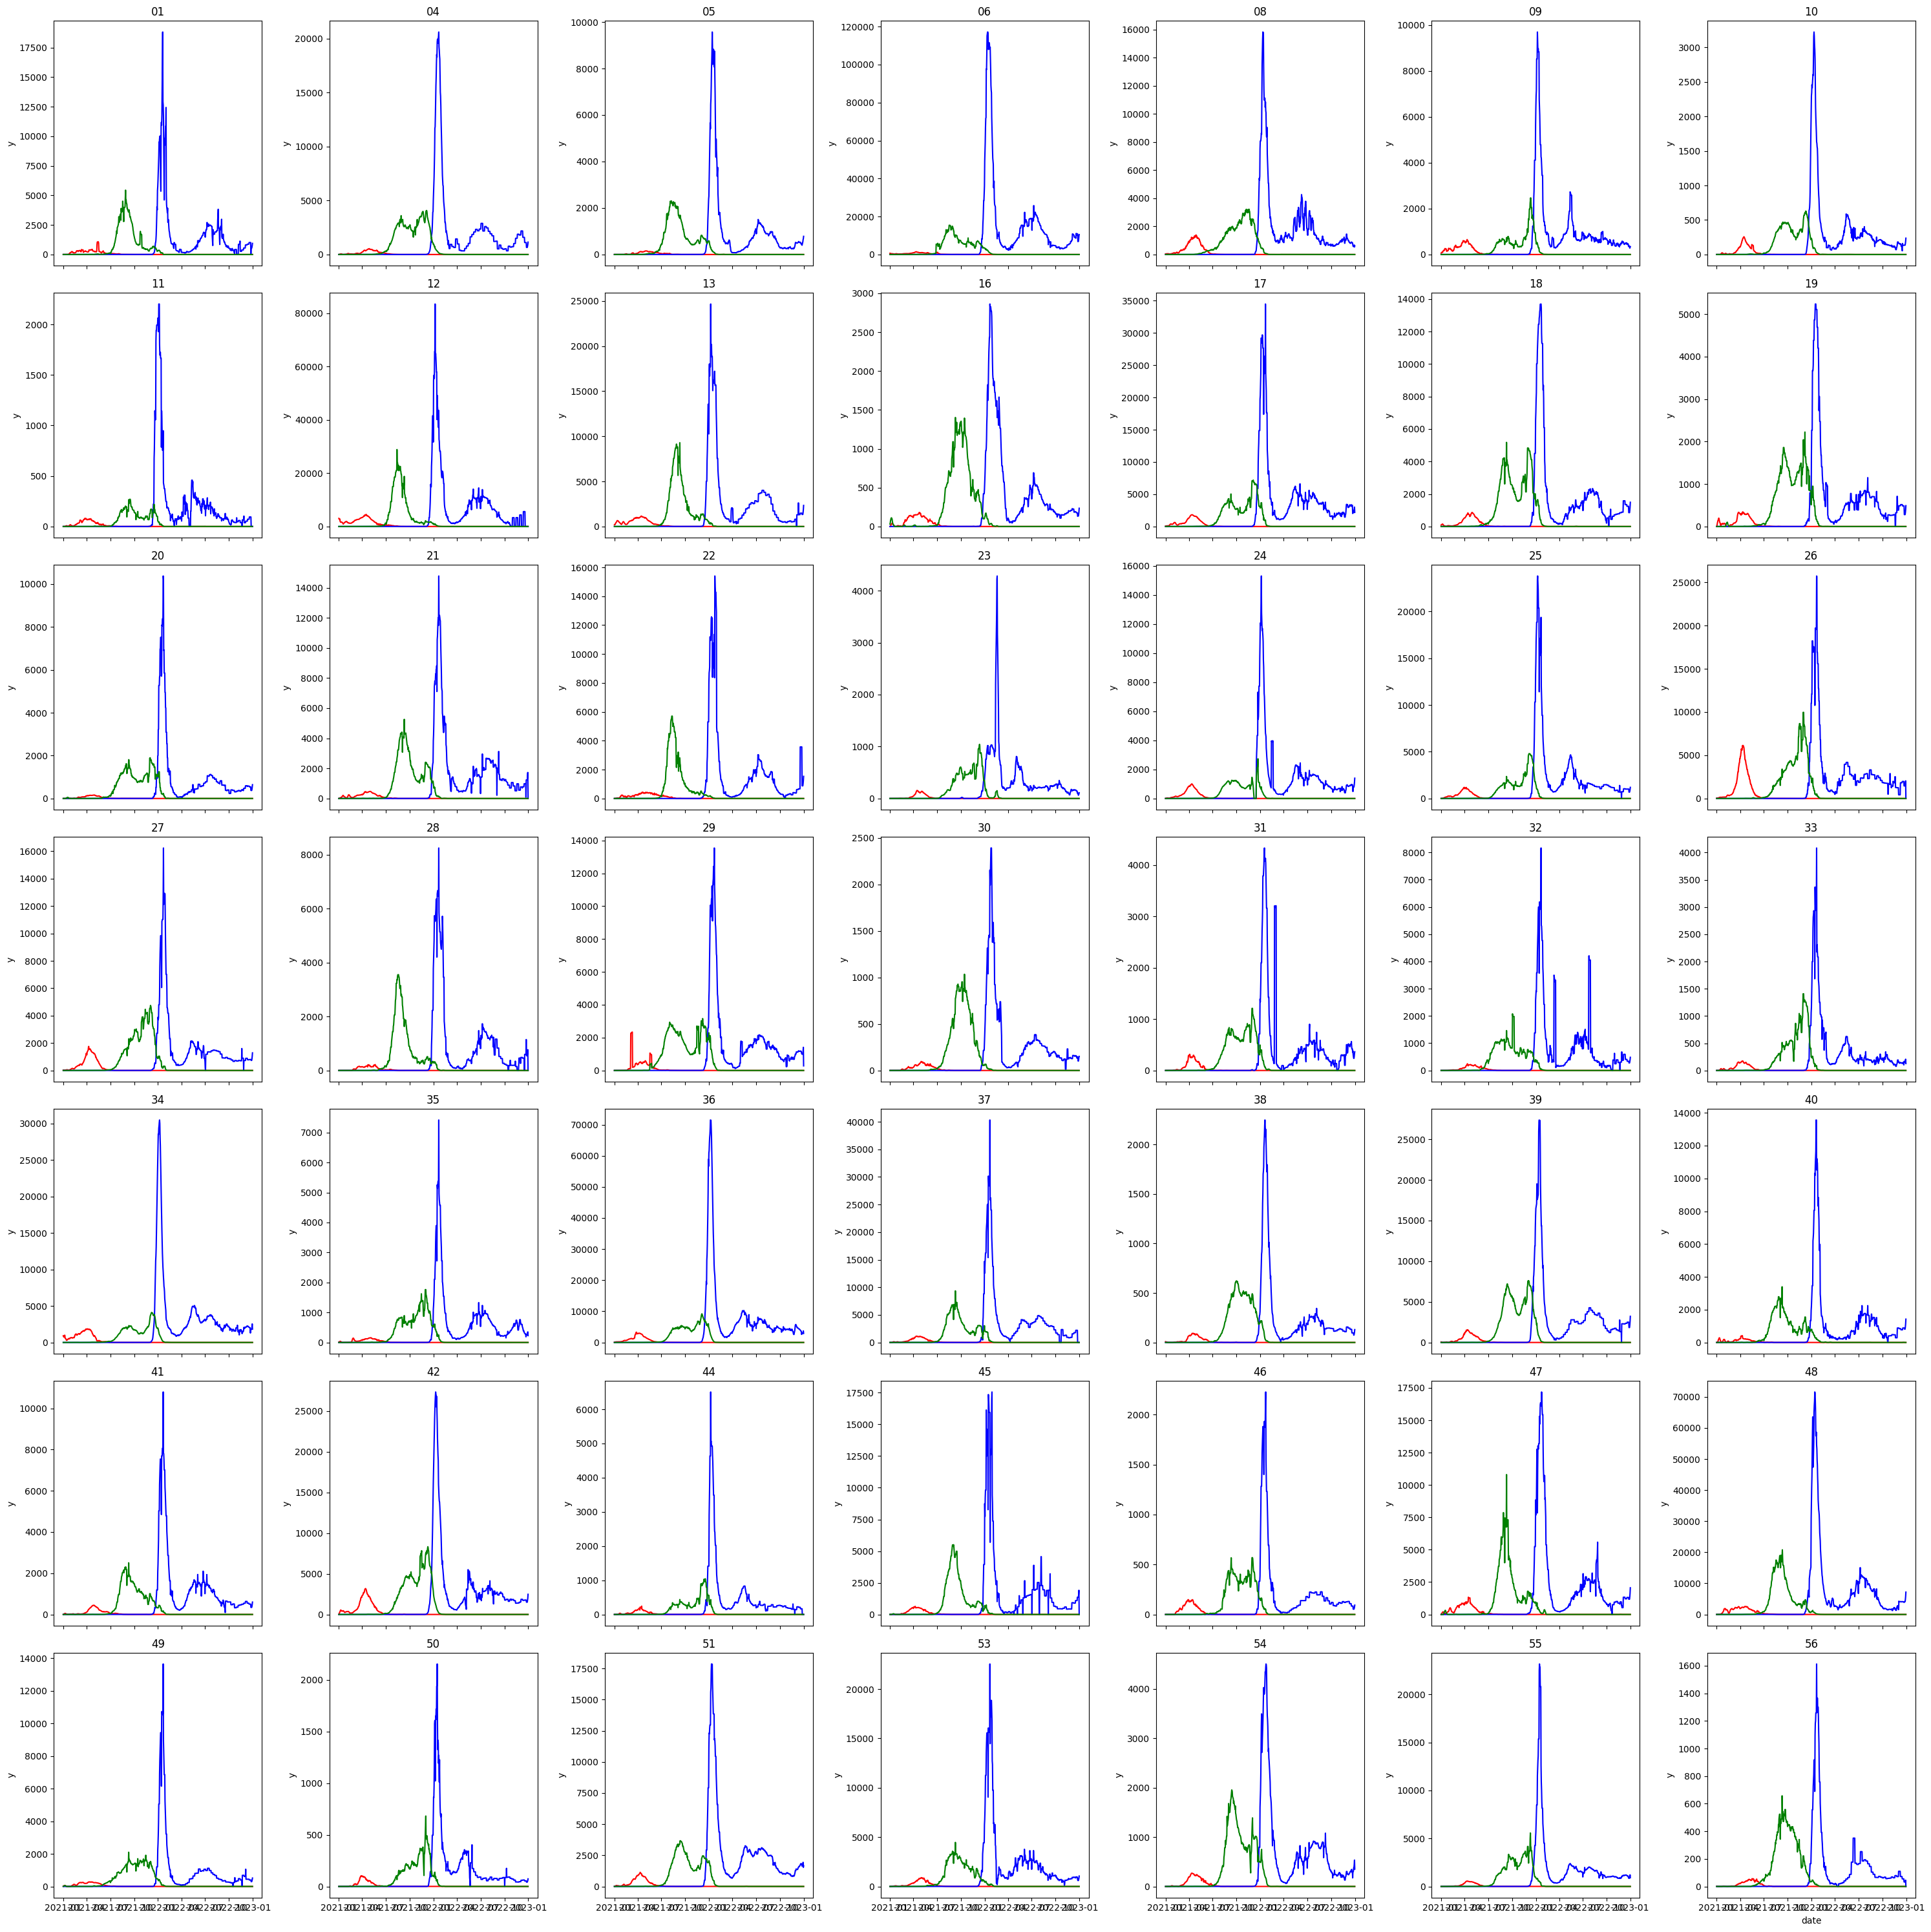

In [134]:
groups = fully_combined_rolling['location'].unique()
fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(30, 30), sharex=True)

axes = axes.flatten()

for ax, g in zip(axes, groups):
    sub = fully_combined_rolling[fully_combined_rolling['location'] == g]
    ax.plot(sub['date'], sub['Alpha'], color='red')
    ax.plot(sub['date'], sub['Omicron'], color='blue')
    ax.plot(sub['date'], sub['Delta'], color='green')
    ax.set_title(f'{g}')
    ax.set_ylabel('y')

axes[-1].set_xlabel('date')
plt.tight_layout()
plt.show()


In [135]:
fully_combined_rolling.to_csv('../processed data/state_level/rolled_covariates_state_level.csv', index=False)